In [142]:
import numpy as np
import torch
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import sklearn
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [143]:
def c2st(
    X: torch.Tensor,
    Y: torch.Tensor,
    seed: int = 1,
    n_folds: int = 5
) -> torch.Tensor:
    """Classifier-based 2-sample test returning accuracy, modified from SBIBM
    Args:
        X: Sample 1
        Y: Sample 2
        seed: Seed for sklearn
        n_folds: Number of folds. Initially set to 5
    """
    ndim = X.shape[1]
    data = np.concatenate((X, Y))
    target = np.concatenate(
        (
            np.zeros((X.shape[0],)),
            np.ones((Y.shape[0],)),
        )
    )
    X_train, X_test, y_train, y_test=sklearn.model_selection.train_test_split(data, target, test_size=0.2, random_state=None, shuffle=True)
    mlp = MLPClassifier(max_iter=10000)
    parameter_space = {
        'hidden_layer_sizes': [(ndim,ndim)],
        'solver': ['adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }
    shuffle = KFold(n_splits=5, shuffle=True, random_state=seed)
    clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=shuffle)
    clf.fit(X_train, y_train)
    #means = clf.cv_results_['mean_test_score']
    #stds = clf.cv_results_['std_test_score']
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        #print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    #print('Best parameters found:\n', clf.best_params_)
    y_pred=clf.predict(X_test)
    return accuracy_score(y_test, y_pred)


In [144]:
def compare(method, param_set):
    # Load data
    folder_path = '/Users/E_V_/Documents/GitHub/Trial/sbi-grn/Final_noisy_data/' 
    #just set this to your github folder here
    
    pattern = folder_path + method + '/*set'+str(param_set)+'*.csv'
    file = glob.glob(pattern)
    file_path = file[0]  
    df_neural = pd.read_csv(file_path,header=0,names=['k1','k2','k3','a1','a2','a3'])
    pattern = folder_path + 'SMC/'+'*set*'+str(param_set)+'.out'
    smc_file= glob.glob(pattern)
    df_smc = pd.read_csv(smc_file[0],header=0, delimiter=' ',names=['k1','k2','k3','a1','a2','a3'])
    X = torch.tensor(df_neural.values)
    Y = torch.tensor(df_smc.values)
    c2st_score=c2st(X,Y)
    return(c2st_score)

In [145]:
c2st_list=[]
for method in ['SNRE','SNLE']:
    for param_set in range(1,6):
        compare(method,param_set)
        c2st_list.append([method, str(param_set), compare(method,param_set)])


In [141]:
# a bit of trial for SNPE, SNRE, SNLE results inter-comparison
df_snpe = pd.read_csv('/Users/E_V_/Documents/GitHub/Trial/sbi-grn/Final_noisy_data/SNPE/ss_6p_set1.csv',header=0,names=['k1','k2','k3','a1','a2','a3'])
X = torch.tensor(df_snpe.values)
df_snre=pd.read_csv('/Users/E_V_/Documents/GitHub/Trial/sbi-grn/Final_noisy_data/SNRE/6p-5*3000_unnorm_ss_noisy_set1.csv',header=0,names=['k1','k2','k3','a1','a2','a3'])
Y=torch.tensor(df_snre.values)
df_snle=pd.read_csv('/Users/E_V_/Documents/GitHub/Trial/sbi-grn/Final_noisy_data/SNLE/FINAL_SNLE_noise_SS-6p(k1, k2, k3, a1, a2, a3)-param_set1-5*3000.csv',header=0,names=['k1','k2','k3','a1','a2','a3'])
Z=torch.tensor(df_snle.values)
c2st(X,Y)

1.0

In [91]:
SNRE_mean_C2ST=np.mean([c2st_list[i][2] for i in range(5)])
SNLE_mean_C2ST=np.mean([c2st_list[i][2] for i in range(5,10)])
SNRE_std_C2ST=np.std([c2st_list[i][2] for i in range(1,5)])
SNLE_std_C2ST=np.std([c2st_list[i][2] for i in range(5,10)])

In [146]:
c2st_scores=[SNLE_mean_C2ST,SNRE_mean_C2ST,0.6969]
c2st_std=[SNLE_std_C2ST,SNRE_std_C2ST,0.069]
algorithm=['SNLE','SNRE','SNPE (NOT REAL)']

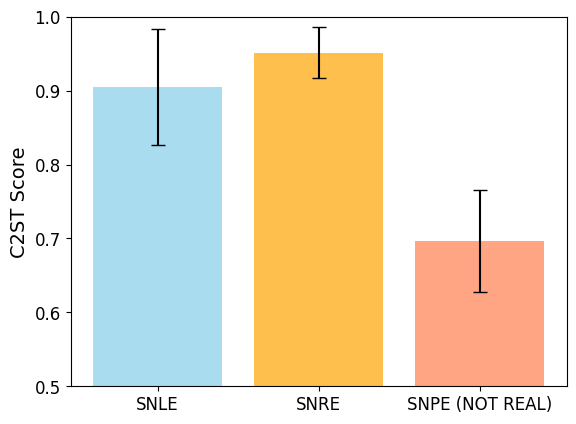

In [147]:
colors = ['skyblue', 'orange','coral']
plt.errorbar(algorithm, c2st_scores, yerr=c2st_std, fmt='o', color='None', ecolor='black', capsize=5)
plt.bar(algorithm,c2st_scores,color=colors,alpha=0.7)
plt.ylim(0.5,1)
plt.ylabel('C2ST score')
#increase font size of y axis labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('C2ST Score', fontsize=14)



plt.savefig('C2ST_score.png',dpi=400)